# Import Libraries

In [1]:

import numpy as np
from random import sample
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import math
import collections

# #Import the Reward and Transition Matrix from the xls file

In [2]:

#Import the reward table and the transition matrix
r_table = pd.read_excel('environment_matrices.xlsx', sheet_name ='rewards', index_col=0)
state_value_function = pd.read_excel('environment_matrices.xlsx', sheet_name ='State value function')
transition_matrix = pd.read_excel('environment_matrices.xlsx', sheet_name ='transition',index_col=0)

# Initialize important parameters and Q matrix

In [3]:

#Initialize parameters
total_episodes = 10000 #Total episodes
number_of_steps = 100 #Maximum steps per episode
T = 0.5 #For the Boltzamann's formula

#Q Learning parameters
alpha = 0.2 #Learning rate
gamma = 0.99 #Discount rate

#Initialization of the Q matrix
q_table = pd.DataFrame(np.matrix(np.zeros([16,4])).astype("float32"), columns = transition_matrix.columns, index = transition_matrix.index)
q_table.head()

,UP,DOWN,RIGHT,LEFT
A,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0


In [4]:
#%% Define the optimal state value table
optimal_state_value_function = np.array(state_value_function)
optimal_state_value_function

# plot_values(optimal_state_value_function)

array([[-6, -5, -4, -5],
       [-5,  0, -3,  0],
       [-4, -3, -2,  0],
       [ 0, -2, -1,  0]], dtype=int64)

# Boltzmann (softmax) policy function

In [5]:
e = 2.71828 #Source : https://en.wikipedia.org/wiki/E_(mathematical_constant)

def softmax_policy(state, T):
    
    #Initialize Vectors with max length = 4, based on the avaliable number of moves  
    action_vector = deque(maxlen=4)
    action_nominator = deque(maxlen=4)
    action_probability_distribution_vector = deque(maxlen=4)
    
    actions_list = ["UP", "DOWN", "RIGHT", "LEFT"]
  
    action_vector = q_table.loc[state, :] # Vector of the Q matrix based on my current state
    print("Action Vector from Q Table", action_vector)
    
    
    #Map every element of the vector to a value of e ^ action_vector[i]/T, where action_vector[i] = Q[i] (4 actions)
    sum_denominator = 0 # initialize summary for the calculation of the formula
    for i in range(4):
        action_nominator.append(e**(action_vector[i]/T)) # Calculate action nominator value
        sum_denominator += e**(action_vector[i]/T) # Add the value to the summary
    
    print("Action Nominator: ", action_nominator)
    print("Sum Denominator", sum_denominator)
    
    print("SIZE Action Nominator: ", action_nominator.maxlen)

                               
    #Calculate the probability distribution                          
    for i in range(4):
        action_probability_distribution_vector.append(action_nominator[i]/sum_denominator) #Append value in the vector
    
    print("Action Probability Distribution: ", action_probability_distribution_vector)

    
    rand_val = np.random.uniform(0, 1)
    prob_sum = 0
    for i, prob in enumerate(action_probability_distribution_vector):
        prob_sum += prob
        if rand_val <= prob_sum:
            action = i # Based on the probability dirstribution, return the number of action 0-3
            break
            
    action = str(action) #Convert the integer action value to string
    
    #Map the numerical value to the action 
    if (action == '0'):
        action = action.replace('0', 'UP')
    elif (action == '1'):
        action = action.replace('1','DOWN')
    elif (action== '2'):
        action = action.replace('2', 'RIGHT')
    else:
        action = action.replace('3', 'LEFT')
    
    
    print("Action", action)
    
    return action

# 'execute_action' Function

In [6]:
# Execution of the action selected from policy.
def execute_action(state, action):
    next_state = transition_matrix.loc[state,action] #return the next state
    reward = r_table.loc[state, next_state]
    end_episode_states = ['F', 'H', 'L', 'M', 'P']
    done = False #done is a flag to determine if my algorithm is going to terminate or not
    if (next_state in end_episode_states):
        done = True
    print('Current state', state)
    print('Next state', next_state)
    print ('Done', done)
    
    
    return next_state, reward, done

# 'update_Q' Function

In [7]:
#Update Q
def update_Q(current_state, next_state, action, reward, alpha, gamma):
    q_old = q_table.loc[current_state, action] #OLD Q value
    q_new = q_old + alpha * (reward + gamma * max(q_table.loc[next_state,:] - q_old))
    #q_new_values.append(q_new) # # add the new q value to a list with all the q new values
    q_table.loc[current_state, action] = q_new
    
    print('Old Q value:       ', q_old)
    print('Updated Q value (Q new): ', q_new)

# Train the Agent

In [8]:
#Training the agent
sum_reward = 0
#episodes_rewards_list_per_10 = []


#Main
episodes_rewards_list = []
window = 100
# initialize average rewards
average_reward = deque(maxlen=total_episodes)
# initialize best average reward as negative infinity
best_average_reward = -math.inf
# initialize monitor for most recent rewards
check_rewards = deque(maxlen=window)

#EPISODES
for episode in range(1, total_episodes + 1):
    current_state = 'A'
    episode_reward = 0
    # Decide the value of epsilon before the start of the episode
    for step in range (number_of_steps):
        #Choose action depending on the value of epsilon
        action = softmax_policy(current_state, T)
        
        #Execute Action and calculate the next state, the reward and check if the episode is finished
        next_state, reward, done = execute_action(current_state, action)
        
        # Update the Q Matrix based on the new values
        update_Q(current_state, next_state, action, reward, alpha, gamma)
        current_state = next_state
        
        episode_reward += reward 
        
        if done:
            check_rewards.append(episode_reward)
            break

    if episode >= 100:
        average_reward = np.mean(check_rewards)
        if average_reward > best_average_reward:
            best_average_reward = average_reward
    print("\rEpisode {}/{} || Best average reward {}".format(episode, total_episodes, best_average_reward), end="")

    
    if best_average_reward > 83:
        print('\nThe environment is solved in {} episodes.'.format(episode-1), end = "")
        break
    
    episodes_rewards_list.append(episode_reward)
    print("\rThe reward for this episode is: {}".format(episode_reward))
    
    episode_reward = 0

Action Vector from Q Table UP       0.0
DOWN     0.0
RIGHT    0.0
LEFT     0.0
Name: A, dtype: float32
Action Nominator:  deque([1.0, 1.0, 1.0, 1.0], maxlen=4)
Sum Denominator 4.0
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.25, 0.25, 0.25, 0.25], maxlen=4)
Action UP
Current state A
Next state A
Done False
Old Q value:        0.0
Updated Q value (Q new):  -0.2
Action Vector from Q Table UP      -0.2
DOWN     0.0
RIGHT    0.0
LEFT     0.0
Name: A, dtype: float32
Action Nominator:  deque([0.6703202223972867, 1.0, 1.0, 1.0], maxlen=4)
Sum Denominator 3.6703202223972866
SIZE Action Nominator:  4
Action Probability Distribution:  deque([0.1826326265231059, 0.2724557911589647, 0.2724557911589647, 0.2724557911589647], maxlen=4)
Action UP
Current state A
Next state A
Done False
Old Q value:        -0.2
Updated Q value (Q new):  -0.36040000239014625
Action Vector from Q Table UP      -0.3604
DOWN     0.0000
RIGHT    0.0000
LEFT     0.0000
Name: A, dtype: float32
Action N

# Calculate Average Rewards per 100 Episodes

In [9]:
sum_rewards = 0
avg_rewards_per_50 = []

for i in range (1, len(episodes_rewards_list)+1):
    sum_rewards += episodes_rewards_list[i-1] 
    if (i%50) == 0 :
        avg_rewards_per_50.append(sum_rewards/50)
        sum_rewards=0
    if (i==len(episodes_rewards_list)):
        if (i%50==0):
            break
        else:
            avg_rewards_per_50.append(sum_rewards/(i%50))
        
avg_rewards_per_50

[55.16, 95.0, 95.0]

In [10]:
df = pd.DataFrame()
df = df.fillna(0)
df['Avg_Reward'] = avg_rewards_per_50
df['Episodes'] = (df.index+1)*50

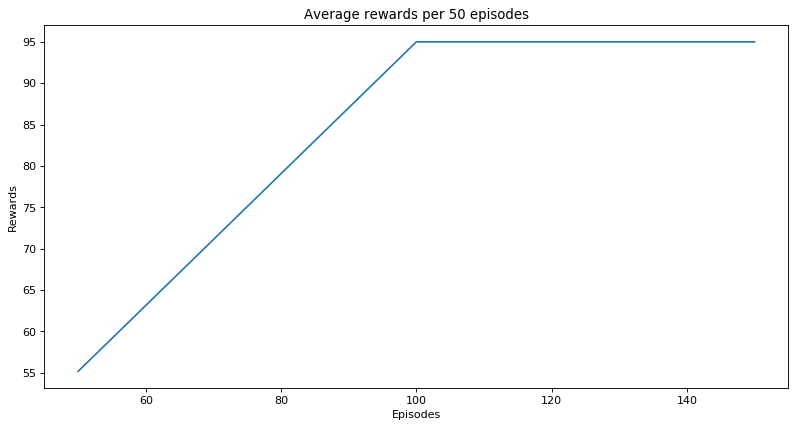

In [11]:
#Plot the average rewards per 50 episodes
plt.figure(figsize=(12,6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Average rewards per 50 episodes')
plt.plot(df['Episodes'], df['Avg_Reward'])

# Calculate Average Rewards per 10 Episodes

In [12]:

sum_rewards = 0
avg_rewards_per_10 = []

for i in range (1, len(episodes_rewards_list)+1):
    sum_rewards += episodes_rewards_list[i-1] 
    if (i%10) == 0 :
        avg_rewards_per_10.append(sum_rewards/10)
        sum_rewards=0
    if (i==len(episodes_rewards_list)):
        if (i%10==0):
            break
        else:
            avg_rewards_per_10.append(sum_rewards/(i%10))
        
avg_rewards_per_10

len(avg_rewards_per_10)

11

In [13]:
df_10 = pd.DataFrame()
df_10 = df_10.fillna(0)
df_10['Avg_Reward'] = avg_rewards_per_10
df_10['Episodes'] = (df_10.index+1)*10

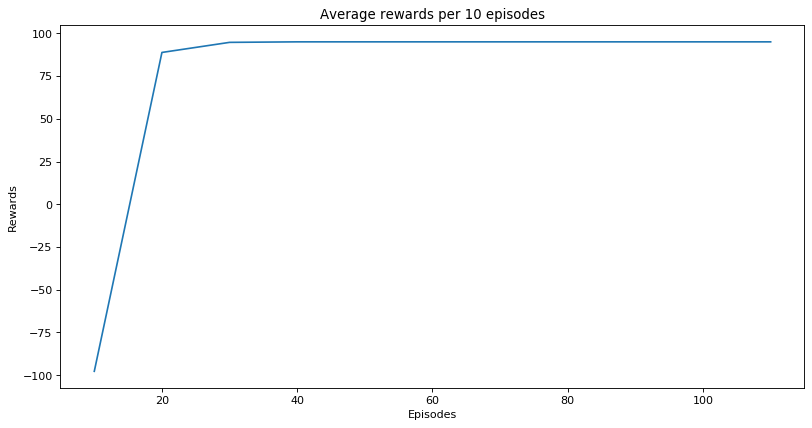

In [14]:

#Plot the average rewards per 10 episodes
plt.figure(figsize=(12,6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('Average rewards per 10 episodes')
plt.plot(df_10['Episodes'], df_10['Avg_Reward'])

# Calculate Reward per episode

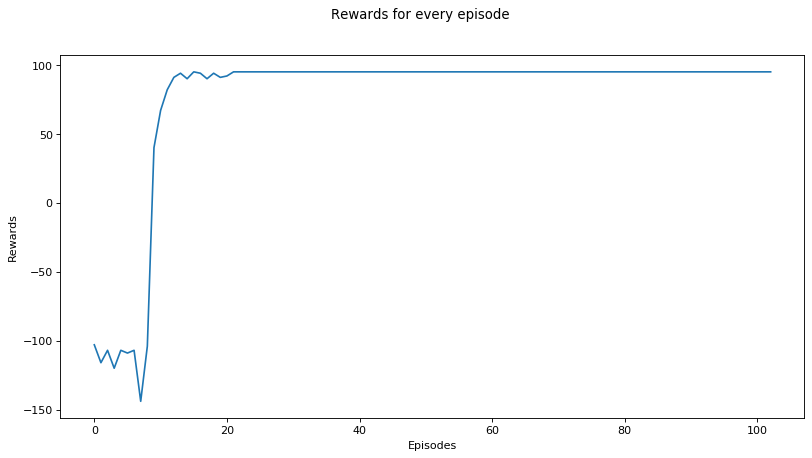

In [15]:
#%% Plot the reward for every episode
reward_per_episode = pd.DataFrame(np.asarray(episodes_rewards_list)) 
reward_per_episode['episodes'] = reward_per_episode.index
reward_per_episode.columns = ['total_reward', 'episodes']


plt.figure(figsize=(12, 6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.suptitle('Rewards for every episode')
plt.plot(reward_per_episode['episodes'], reward_per_episode['total_reward'])